## Problem Set 2
### Joseph Denby

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
import timeit

%matplotlib notebook

#### 1. Kernel Density Estimator
##### a.

In [75]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

In [76]:
X = np.arange(18,96)
Y = np.arange(1,8)

In [77]:
Y,X = np.meshgrid(Y,X)

<IPython.core.display.Javascript object>


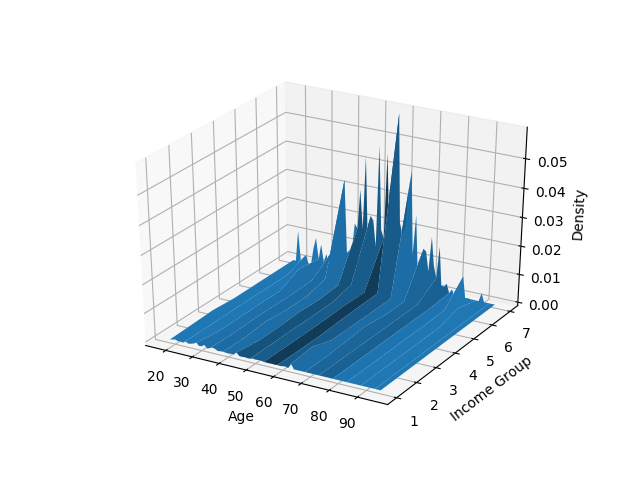

In [78]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, bq_data, rstride =5)
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Density')
plt.show()

##### b.

In [35]:
from scipy.stats import gaussian_kde

In [36]:
ages_vec = np.arange(18, 96)
abils_vec = np.arange(1,8)
abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])

I pick a relatively low bandwidth here (1.0) because I am more interested in using KDE to get an understanding of the data as it stands and less about how I might use the data to predict future information. So, I am less concerned with a low bandwidth value's tendency to overfit and more interested in capturing the variance within the current dataset.

In [79]:
bandwidth = 1.0

prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(abils_midpt, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

In [80]:
abils_mat, ages_mat = np.meshgrid(abils_vec, ages_vec)

In [81]:
coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
BQkde = density(coords).reshape(ages_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

<IPython.core.display.Javascript object>


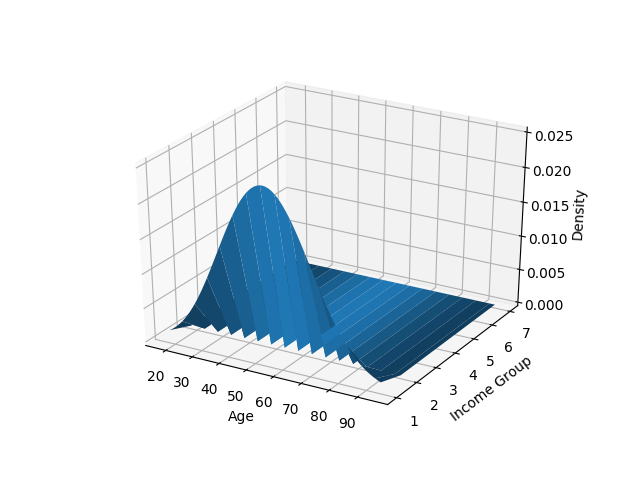

In [82]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, abils_mat, BQkde_scaled, rstride =5)
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Density')
plt.show()

In [62]:
print("The estimated density of bequest recipients who are 61 and in the 6th lifetime income category is: \n{}".format(BQkde_scaled[61,6]))

The estimated density of bequest recipients who are 61 and in the 6th lifetime income category is: 
1.1566613122104455e-78


#### 3. Parallel Computing


In [5]:
from dask.distributed import Client
from dask import compute, delayed
import dask.multiprocessing

In [16]:
auto = pd.read_csv('Auto.csv',na_values='?')
auto = auto.dropna()
auto['mpg_high'] = auto.mpg.apply(lambda x: int(x>=np.median(auto.mpg)))

In [17]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0


#### a.

In [18]:
X = auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']]
y = auto['mpg_high']

In [32]:
N_bs = 100

MSE_vec_bs = np.zeros(N_bs)
seed_vec = np.arange(1, N_bs+1)

start_time = timeit.default_timer()

for bs_ind in range(N_bs):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35, random_state = seed_vec[bs_ind])
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_bs[bs_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', bs_ind, ' is', MSE_vec_bs[bs_ind])

MSE_bs = MSE_vec_bs.mean()
MSE_bs_std = MSE_vec_bs.std()
print('test estimate MSE bootstrap=', MSE_bs,
      'test estimate MSE standard err=', MSE_bs_std)

elapsed_time = timeit.default_timer() - start_time
print('Elapsed time=', elapsed_time, 'seconds')

MSE for test set 0  is 0.050724637681159424
MSE for test set 1  is 0.12318840579710146
MSE for test set 2  is 0.10144927536231885
MSE for test set 3  is 0.08695652173913043
MSE for test set 4  is 0.09420289855072464
MSE for test set 5  is 0.10144927536231885
MSE for test set 6  is 0.13043478260869565
MSE for test set 7  is 0.10869565217391304
MSE for test set 8  is 0.09420289855072464
MSE for test set 9  is 0.11594202898550725
MSE for test set 10  is 0.10144927536231885
MSE for test set 11  is 0.07246376811594203
MSE for test set 12  is 0.10144927536231885
MSE for test set 13  is 0.10869565217391304
MSE for test set 14  is 0.09420289855072464
MSE for test set 15  is 0.10144927536231885
MSE for test set 16  is 0.10144927536231885
MSE for test set 17  is 0.08695652173913043
MSE for test set 18  is 0.10869565217391304
MSE for test set 19  is 0.08695652173913043
MSE for test set 20  is 0.10869565217391304
MSE for test set 21  is 0.07246376811594203
MSE for test set 22  is 0.094202898550724

The average error rate is 0.101 $\pm$ 0.0213. Overall, the computation took about 0.646 seconds to complete serially.

#### b.

In [37]:
def bs_log(bs_ind, X, y, seed):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35, random_state = seed)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    results = np.array([((y_test - y_pred) ** 2).mean()]) 
    return results



In [48]:
start_time = timeit.default_timer()

lazy_vals = []
for bs_ind in range(N_bs):
    lazy_vals.append(delayed(bs_log)(bs_ind, X, y, seed_vec[bs_ind]))

results_par = compute(*lazy_vals, get=dask.multiprocessing.get, num_workers=4)
MSE_bs = np.vstack(list(results_par)).mean()
MSE_bs_std = np.vstack(list(results_par)).std()

print('test estimate MSE bootstrap=', MSE_bs,
      'test estimate MSE standard err=', MSE_bs_std)

elapsed_time = timeit.default_timer() - start_time
print('Elapsed time=', elapsed_time, 'seconds')

test estimate MSE bootstrap= 0.10115942028985508 test estimate MSE standard err= 0.021297938501531995
Elapsed time= 0.6558097189990804 seconds


The parallelized version yields the same MSE and standard error estimates, but is slightly slower (perhaps due to initialization overhead.) With a larger dataset I am sure the parallelized version would be far more efficient.